In [2]:
import numpy as np
import geopandas as gpd
import os
import pandas as pd
from scipy import stats as scipy_stats
from scipy.signal import convolve2d
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import richdem as rd
import matplotlib.pyplot as plt
import rasterstats
from shapely.geometry import Polygon

# Import libs
import sys
module_path = os.path.abspath(os.path.join('..', '..', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)
from s3utils import *

Much of this notebook comes from: https://www.youtube.com/watch?v=VIr-pejky6E

## Bring in dsm data

In [3]:
S3R = S3Helper('roof-index')
dsm_path = "missoula/geospatial/downtown_dsm.tif" 
dsm = S3R.read_tif_from_s3_as_rio(dsm_path) 

slope = S3R.read_tif_from_s3_as_rio("missoula/geospatial/downtown_slope.tif")

## Define Hyperparameters

In [4]:
# Maximum slope (in degrees) value at which we consider a rooftop to be 'flat'
slope_threshold = 11

# Minimum percentage of flat area on a roof for the roof to be classified as 'flat'
area_threshold = 9

## Bring in vector data

In [5]:
bldgs_path = "missoula/geospatial/downtown_bldgs.zip"
bldgs = S3R.read_shp_from_s3_as_gpd(bldgs_path).to_crs(6514)
bldgs

,fid,AVG_HEIGHT,MIN_LAG,area_sq_ft,geometry
0,1.0,27.32460,3202.73,44334.900,"MULTIPOLYGON (((257091.482 300124.221, 257092...."
1,2.0,11.80030,3204.72,5449.480,"POLYGON ((257170.740 300266.436, 257176.161 30..."
2,3.0,11.44360,3205.74,3658.490,"POLYGON ((257170.172 300185.933, 257168.625 30..."
3,4.0,30.45860,3205.99,13970.200,"MULTIPOLYGON (((257408.449 300123.800, 257416...."
4,5.0,10.99220,3204.42,6748.850,"POLYGON ((257175.485 300291.266, 257164.191 30..."
...,...,...,...,...,...
958,959.0,10.41030,3217.27,566.998,"POLYGON ((258263.976 301156.751, 258261.521 30..."
959,960.0,17.13810,3214.29,2976.740,"POLYGON ((258224.819 301179.597, 258233.395 30..."
960,961.0,16.08160,3217.24,1456.870,"POLYGON ((258300.759 301228.699, 258299.919 30..."
961,962.0,9.34612,3216.50,272.249,"POLYGON ((258217.425 301179.456, 258220.866 30..."


## Plot buildings and slope

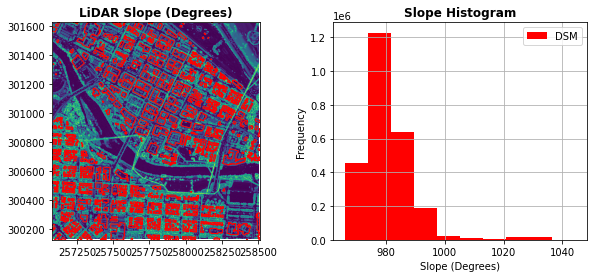

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
show(slope, ax = ax1, title= 'LiDAR Slope (Degrees)')
bldgs.plot(ax = ax1, facecolor='None', edgecolor='red')
show_hist(dsm, title='Slope Histogram', ax=ax2, label='DSM')
ax2.set_xlabel('Slope (Degrees)')
plt.show()

## Determine Roof Pitch

In [7]:
def calc_flat(slope, bldgs, st=11, at=9):
    
    """
    slope: rio object of slope.
    bldgs: gdf of building footprints.
    st: int representing the slope at which a pixel is considered flat.
    at: int representing percentage of a rooftop that must be flat for the whole roof to be classified as flat. 
    """
    
    slope_arr = slope.read(1)
    affine = slope.transform
    
    # Convert all slope values greater than the slope threshold to zero, everything else to zero.
    slope_arr = np.where(slope_arr > st, 0, 1)


    # If a pixel's slope is greater than slope_threshold degrees, assign a 0, otherwise assign a 1. 
    # Then sum the pixels and calculate area.
    def flat_area(x):

        flat_count = np.sum(x)

        return flat_count * affine[0] * -affine[4]

    # Calculate zonal statistics
    zstats = rasterstats.zonal_stats(bldgs, slope_arr, affine=affine,
        nodata=dsm.nodata, geojson_out=True, add_stats={'flat_area': flat_area})

    # Extract flat area from stats
    fa = []
    for bldg_stats in zstats:
        bldg_fa = (bldg_stats['properties']['fid'], bldg_stats['properties']['flat_area']*3.28084)
        fa.append(bldg_fa)

    # Merge buildings and flat area geodataframes.
    fa_df = gpd.GeoDataFrame(fa, columns=['fid', 'fa_sq_ft'])
    full_data = pd.merge(bldgs, fa_df)
    full_data = full_data.astype({'fa_sq_ft': np.float64}, copy=True)
    
    # Calculate how much of the building area is flat
    full_data['fa_perc'] = (full_data['fa_sq_ft'] / full_data['area_sq_ft']) * 100
    # Filter out buildings whose flat area is less than the threshold
    full_data['flat'] = (full_data.fa_perc > at)
    
    return full_data

flat_buildings = calc_flat(slope, bldgs, slope_threshold, area_threshold)

/Users/colinbrust/projects/rooftop-index/venv/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1097: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


## Plot flat buildings

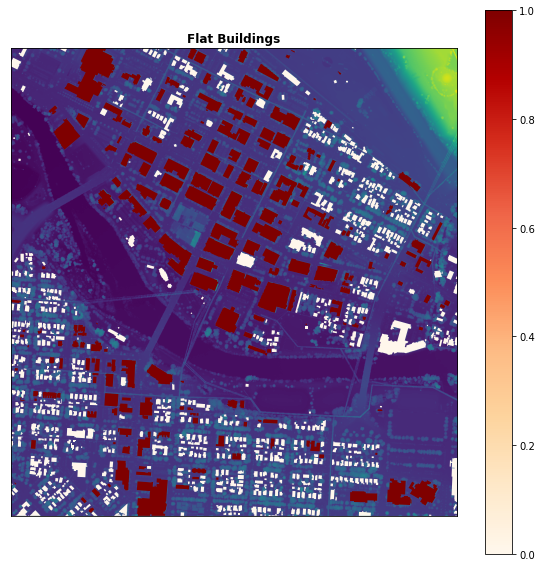

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
show(dsm, ax = ax, title= 'Flat Buildings')
flat_buildings.plot(column='flat', legend=True, ax=ax, cmap='OrRd')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.show()

## Calibrate Hyperparameters
### Read ground truth data
#### None of the below code is necessary for putting together the code library

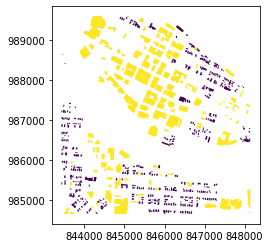

In [55]:
truth = S3R.get_shp_from_s3_as_gpd('/missoula/geospatial/flat_ground_truth.zip') 
truth.plot(column='flat')

ids = [int(x) for x in truth['fid']]
flat = truth['flat']

# Didn't quite classify all buildings so remove buildings without a ground truthing.
truth_dict = dict(zip(ids, flat))
truth_dict = {k: v for k, v in truth_dict.items() if not np.isnan(v)}

In [85]:
# This is essentially equivalent to MSE for binary variables
from sklearn.metrics import brier_score_loss as bss
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

min_bss = 1
pred_dict = {}

# Calculate loss for all reasonable slope and area hyperparameters.
for slp in range(30):
    for area in range(30):
        # Calculate flat area
        preds = calc_flat(slope, bldgs, slp, area)
        preds = dict(zip([int(x) for x in full_data['fid']], full_data['flat']))
        # Select values that we have ground truth for
        preds = {k: v for k, v in preds.items() if k in truth_dict}
        # Calculate loss
        loss = bss(list(truth_dict.values()), list(preds.values()))
        pred_dict[(slp, area)] = loss
        print('Slope: {}, Area: {}, Loss: {}'.format(slp, area, round(loss, 4)))
        if loss < min_bss:
            min_bss = loss
            opt_params = (slp, area)
        

Slope: 0, Area: 0, Loss: 0.2485
Slope: 0, Area: 1, Loss: 0.2796
Slope: 0, Area: 2, Loss: 0.2738
Slope: 0, Area: 3, Loss: 0.2699
Slope: 0, Area: 4, Loss: 0.2699
Slope: 0, Area: 5, Loss: 0.2699
Slope: 0, Area: 6, Loss: 0.2699
Slope: 0, Area: 7, Loss: 0.2699
Slope: 0, Area: 8, Loss: 0.2699
Slope: 0, Area: 9, Loss: 0.2699
Slope: 0, Area: 10, Loss: 0.2699
Slope: 0, Area: 11, Loss: 0.2699
Slope: 0, Area: 12, Loss: 0.2699
Slope: 0, Area: 13, Loss: 0.2699
Slope: 0, Area: 14, Loss: 0.2699
Slope: 0, Area: 15, Loss: 0.2699
Slope: 0, Area: 16, Loss: 0.2699
Slope: 0, Area: 17, Loss: 0.2699
Slope: 0, Area: 18, Loss: 0.2699
Slope: 0, Area: 19, Loss: 0.2699
Slope: 0, Area: 20, Loss: 0.2699
Slope: 0, Area: 21, Loss: 0.2699
Slope: 0, Area: 22, Loss: 0.2699
Slope: 0, Area: 23, Loss: 0.2699
Slope: 0, Area: 24, Loss: 0.2699
Slope: 0, Area: 25, Loss: 0.2699
Slope: 0, Area: 26, Loss: 0.2699
Slope: 0, Area: 27, Loss: 0.2699
Slope: 0, Area: 28, Loss: 0.2699
Slope: 0, Area: 29, Loss: 0.2699
Slope: 1, Area: 0, L

Slope: 8, Area: 13, Loss: 0.1165
Slope: 8, Area: 14, Loss: 0.1359
Slope: 8, Area: 15, Loss: 0.1592
Slope: 8, Area: 16, Loss: 0.1786
Slope: 8, Area: 17, Loss: 0.1961
Slope: 8, Area: 18, Loss: 0.2078
Slope: 8, Area: 19, Loss: 0.2214
Slope: 8, Area: 20, Loss: 0.235
Slope: 8, Area: 21, Loss: 0.2427
Slope: 8, Area: 22, Loss: 0.2485
Slope: 8, Area: 23, Loss: 0.2544
Slope: 8, Area: 24, Loss: 0.2641
Slope: 8, Area: 25, Loss: 0.2641
Slope: 8, Area: 26, Loss: 0.268
Slope: 8, Area: 27, Loss: 0.2699
Slope: 8, Area: 28, Loss: 0.2699
Slope: 8, Area: 29, Loss: 0.2699
Slope: 9, Area: 0, Loss: 0.7068
Slope: 9, Area: 1, Loss: 0.501
Slope: 9, Area: 2, Loss: 0.2233
Slope: 9, Area: 3, Loss: 0.101
Slope: 9, Area: 4, Loss: 0.0641
Slope: 9, Area: 5, Loss: 0.0544
Slope: 9, Area: 6, Loss: 0.0466
Slope: 9, Area: 7, Loss: 0.0369
Slope: 9, Area: 8, Loss: 0.0369
Slope: 9, Area: 9, Loss: 0.035
Slope: 9, Area: 10, Loss: 0.0524
Slope: 9, Area: 11, Loss: 0.0641
Slope: 9, Area: 12, Loss: 0.0796
Slope: 9, Area: 13, Loss:

Slope: 16, Area: 19, Loss: 0.1592
Slope: 16, Area: 20, Loss: 0.1864
Slope: 16, Area: 21, Loss: 0.2019
Slope: 16, Area: 22, Loss: 0.2272
Slope: 16, Area: 23, Loss: 0.2369
Slope: 16, Area: 24, Loss: 0.2544
Slope: 16, Area: 25, Loss: 0.2602
Slope: 16, Area: 26, Loss: 0.2641
Slope: 16, Area: 27, Loss: 0.268
Slope: 16, Area: 28, Loss: 0.2699
Slope: 16, Area: 29, Loss: 0.2699
Slope: 17, Area: 0, Loss: 0.7301
Slope: 17, Area: 1, Loss: 0.7243
Slope: 17, Area: 2, Loss: 0.6369
Slope: 17, Area: 3, Loss: 0.4893
Slope: 17, Area: 4, Loss: 0.3515
Slope: 17, Area: 5, Loss: 0.2544
Slope: 17, Area: 6, Loss: 0.1845
Slope: 17, Area: 7, Loss: 0.1223
Slope: 17, Area: 8, Loss: 0.0893
Slope: 17, Area: 9, Loss: 0.0718
Slope: 17, Area: 10, Loss: 0.0602
Slope: 17, Area: 11, Loss: 0.0505
Slope: 17, Area: 12, Loss: 0.0505
Slope: 17, Area: 13, Loss: 0.0524
Slope: 17, Area: 14, Loss: 0.0544
Slope: 17, Area: 15, Loss: 0.066
Slope: 17, Area: 16, Loss: 0.0796
Slope: 17, Area: 17, Loss: 0.0971
Slope: 17, Area: 18, Loss:

Slope: 24, Area: 24, Loss: 0.2252
Slope: 24, Area: 25, Loss: 0.2505
Slope: 24, Area: 26, Loss: 0.2641
Slope: 24, Area: 27, Loss: 0.268
Slope: 24, Area: 28, Loss: 0.2699
Slope: 24, Area: 29, Loss: 0.2699
Slope: 25, Area: 0, Loss: 0.7301
Slope: 25, Area: 1, Loss: 0.7301
Slope: 25, Area: 2, Loss: 0.7243
Slope: 25, Area: 3, Loss: 0.7107
Slope: 25, Area: 4, Loss: 0.6796
Slope: 25, Area: 5, Loss: 0.6097
Slope: 25, Area: 6, Loss: 0.5437
Slope: 25, Area: 7, Loss: 0.466
Slope: 25, Area: 8, Loss: 0.3883
Slope: 25, Area: 9, Loss: 0.3282
Slope: 25, Area: 10, Loss: 0.268
Slope: 25, Area: 11, Loss: 0.2175
Slope: 25, Area: 12, Loss: 0.1903
Slope: 25, Area: 13, Loss: 0.1573
Slope: 25, Area: 14, Loss: 0.1262
Slope: 25, Area: 15, Loss: 0.1087
Slope: 25, Area: 16, Loss: 0.1087
Slope: 25, Area: 17, Loss: 0.1068
Slope: 25, Area: 18, Loss: 0.1029
Slope: 25, Area: 19, Loss: 0.1068
Slope: 25, Area: 20, Loss: 0.1184
Slope: 25, Area: 21, Loss: 0.1417
Slope: 25, Area: 22, Loss: 0.1612
Slope: 25, Area: 23, Loss: 

<AxesSubplot:>

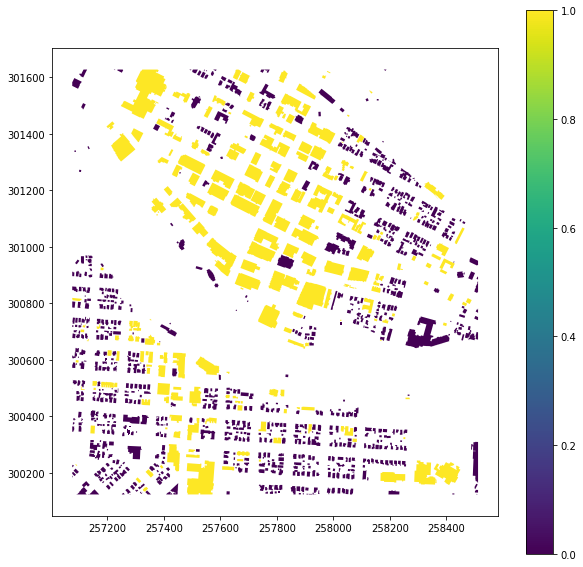

In [94]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
best = calc_flat(slope, bldgs, 11, 9)
best.plot(column='flat', ax=ax, legend=True)